In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib

from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from tqdm import tqdm as tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
class Focus(nn.Module):
    def __init__(self,input_dims):
        super(Focus,self).__init__()
        self.input_dims = input_dims
        self.fc1 = nn.Linear(input_dims,1,bias=False)
    def forward(self,x):
        x = self.fc1(x)
        return x
        

In [3]:
class Classification(nn.Module):
    def __init__(self,input_dims,output_dims):
        super(Classification,self).__init__()
        self.input_dims = input_dims
        self.output_dims = output_dims
        self.fc1 = nn.Linear(input_dims,output_dims)
    def forward(self,x):
        
        x = self.fc1(x)
        if self.output_dims > 1:
            x = x
        else:
            x = torch.sigmoid(x)
        return x

In [4]:
def calculate_loss_focus(gamma,focus_output):
    #print(gamma.shape,focus_output.shape)
    log_outputs = torch.log(focus_output)
    
    loss_ = gamma*log_outputs
    loss_ = torch.sum(loss_,dim=1)
    loss_ = -torch.mean(loss_,dim=0)    
    return loss_ 
    

In [5]:
def calculate_loss_classification(gamma,classification_output,label,criterion,n_patches):
    
    batch = label.size(0)
    classes = classification_output.size(2)
    label = label.repeat_interleave(n_patches)
    classification_output = classification_output.reshape((batch*n_patches,classes))
    loss_ = criterion(classification_output,label)
    
    loss_ = loss_.reshape((batch,n_patches))
    
    loss_ = gamma*loss_
    loss_ = torch.sum(loss_,dim=1)
    loss_ = torch.mean(loss_,dim=0)
    
    return loss_
    

In [6]:
def expectation_step(fc,cl,data,labels):
    batch= data.size(0)
    with torch.no_grad():
        outputs_f = F.softmax(fc(data),dim=1)
        outputs_g = F.softmax(cl(data),dim=2)
        
    outputs_g = outputs_g[np.arange(batch),:,labels]
    p_x_y_z = outputs_f[:,:,0]*outputs_g   #(1-outputs_g)    
    normalized_p = p_x_y_z/torch.sum(p_x_y_z,dim=1,keepdims=True)
    return normalized_p

In [7]:
def maximization_step(p_z,focus,classification,data,labels,focus_optimizer,classification_optimizer,Criterion):    
    
    patches = data.size(1)
    focus_optimizer.zero_grad()
    classification_optimizer.zero_grad()
    
    focus_outputs = F.softmax(focus(data),dim=1)[:,:,0]
    classification_outputs = classification(data) # classification returns output after sigmoid/softmax
    
    
    #print(focus_outputs,classification_outputs)
    
    loss_focus = calculate_loss_focus(p_z,focus_outputs)
    loss_classification = calculate_loss_classification(p_z,classification_outputs,
                                                        labels,Criterion,patches)
    
    print("Focus loss",loss_focus.item())
    print("Classification loss",loss_classification.item())
    loss_focus.backward() 
    loss_classification.backward()
    focus_optimizer.step()
    classification_optimizer.step()
    
    return focus,classification,focus_optimizer,classification_optimizer

0 100
1 100
2 100


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 533.16it/s]


torch.Size([100, 100, 1]) torch.Size([100])


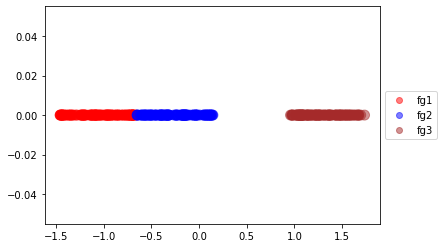

In [8]:
np.random.seed(12)
y = np.concatenate((np.zeros(100),np.ones(100),np.ones(100)*2))
idx= []
for i in range(3):
    print(i,sum(y==i))
    idx.append(y==i)

    
x = np.zeros((300))



np.random.seed(12)

x[idx[0]] = np.random.uniform(low =-1,high =0,size= sum(idx[0]))
x[idx[1]] = np.random.uniform(low =0,high =1,size= sum(idx[1]))
x[idx[2]] = np.random.uniform(low =2,high =3,size= sum(idx[2]))
colors = ['red','green','blue','brown']

x = (x-np.mean(x,axis=0,keepdims=True))/np.std(x,axis=0,keepdims=True)

plt.figure()
scatter = plt.scatter(x,np.zeros(x.shape[0]),c=y,cmap=matplotlib.colors.ListedColormap(colors),alpha=0.5,s=100)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
           handles=scatter.legend_elements()[0],labels=("fg1","fg2","fg3","bg"))


desired_num = 100
mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
m = 100
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,2)
    fg_idx = np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(2,3)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,1)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)
    
    
data = np.transpose(np.dstack(mosaic_list_of_images),axes=(2,0,1))

data = torch.tensor(data,dtype=torch.float32)
labels = torch.tensor(mosaic_label)

print(data.shape,labels.shape)




In [9]:
# data[0],fore_idx[0],mosaic_label[0]

In [10]:
focus = Focus(1)
#print(focus.fc1.weight.data)
focus.fc1.weight.data = torch.tensor([[0.]])
classification = Classification(1,2)
#print(classification.fc1.weight.data)
classification.fc1.weight.data = torch.tensor([[0.1],[-0.1]])
classification.fc1.bias.data = torch.tensor([0.,0.])

Criterion = nn.CrossEntropyLoss(reduction="none") #nn.BCELoss(reduction="none")
focus_optimizer = optim.SGD(focus.parameters(), lr=0.5)
classification_optimizer = optim.SGD(classification.parameters(),lr=0.5)

for i in range(1000):
    p_z = expectation_step(focus,classification,data,labels)
    #print(p_z.shape)
    focus,classification,focus_optimizer,classification_optimizer=maximization_step(p_z
                                                                                ,focus,classification,data,
                                                                                labels,focus_optimizer,
                                                                                classification_optimizer,
                                                                                Criterion)
    
    

Focus loss 4.605170726776123
Classification loss 0.713839590549469
Focus loss 4.605170249938965
Classification loss 0.6911880373954773
Focus loss 4.605170249938965
Classification loss 0.6884853839874268
Focus loss 4.605170249938965
Classification loss 0.6881617903709412
Focus loss 4.605169773101807
Classification loss 0.6881207227706909
Focus loss 4.605170726776123
Classification loss 0.6881147623062134
Focus loss 4.605170249938965
Classification loss 0.6881133913993835
Focus loss 4.605170726776123
Classification loss 0.6881127953529358
Focus loss 4.605170249938965
Classification loss 0.6881122589111328
Focus loss 4.605169773101807
Classification loss 0.6881119012832642
Focus loss 4.605170249938965
Classification loss 0.6881113648414612
Focus loss 4.605170249938965
Classification loss 0.688110888004303
Focus loss 4.605170249938965
Classification loss 0.6881105303764343
Focus loss 4.605169773101807
Classification loss 0.6881099939346313
Focus loss 4.605170249938965
Classification loss 0

Focus loss 4.6051411628723145
Classification loss 0.688029408454895
Focus loss 4.605140209197998
Classification loss 0.6880283355712891
Focus loss 4.60513973236084
Classification loss 0.6880272626876831
Focus loss 4.605139255523682
Classification loss 0.6880261301994324
Focus loss 4.605138778686523
Classification loss 0.6880251169204712
Focus loss 4.605137825012207
Classification loss 0.6880240440368652
Focus loss 4.605136871337891
Classification loss 0.6880229115486145
Focus loss 4.605135917663574
Classification loss 0.6880217790603638
Focus loss 4.605135440826416
Classification loss 0.688020646572113
Focus loss 4.6051344871521
Classification loss 0.6880195736885071
Focus loss 4.605133533477783
Classification loss 0.6880184412002563
Focus loss 4.605132579803467
Classification loss 0.6880171895027161
Focus loss 4.605132102966309
Classification loss 0.6880160570144653
Focus loss 4.605131149291992
Classification loss 0.688014805316925
Focus loss 4.605130195617676
Classification loss 0.68

Focus loss 4.604696750640869
Classification loss 0.687696099281311
Focus loss 4.604689121246338
Classification loss 0.6876921057701111
Focus loss 4.604681968688965
Classification loss 0.6876881122589111
Focus loss 4.604674339294434
Classification loss 0.6876839399337769
Focus loss 4.604666233062744
Classification loss 0.6876798272132874
Focus loss 4.604658603668213
Classification loss 0.6876756548881531
Focus loss 4.604650974273682
Classification loss 0.6876714825630188
Focus loss 4.604642868041992
Classification loss 0.6876672506332397
Focus loss 4.604635238647461
Classification loss 0.6876629590988159
Focus loss 4.6046271324157715
Classification loss 0.6876585483551025
Focus loss 4.604618072509766
Classification loss 0.6876541972160339
Focus loss 4.604609489440918
Classification loss 0.687649667263031
Focus loss 4.6046013832092285
Classification loss 0.6876452565193176
Focus loss 4.604592800140381
Classification loss 0.6876406669616699
Focus loss 4.604583740234375
Classification loss

Focus loss 4.599766254425049
Classification loss 0.6858945488929749
Focus loss 4.599664211273193
Classification loss 0.685863196849823
Focus loss 4.599559307098389
Classification loss 0.6858310699462891
Focus loss 4.599452495574951
Classification loss 0.6857984066009521
Focus loss 4.5993428230285645
Classification loss 0.6857650876045227
Focus loss 4.599230766296387
Classification loss 0.685731053352356
Focus loss 4.599116325378418
Classification loss 0.6856962442398071
Focus loss 4.598998546600342
Classification loss 0.6856607794761658
Focus loss 4.598877906799316
Classification loss 0.6856245398521423
Focus loss 4.598753929138184
Classification loss 0.6855876445770264
Focus loss 4.598628044128418
Classification loss 0.685549795627594
Focus loss 4.5984978675842285
Classification loss 0.6855111718177795
Focus loss 4.59836483001709
Classification loss 0.6854717135429382
Focus loss 4.5982279777526855
Classification loss 0.6854313611984253
Focus loss 4.598088264465332
Classification loss 

Focus loss 2.2794318199157715
Classification loss 0.17410403490066528
Focus loss 2.270906925201416
Classification loss 0.1738584190607071
Focus loss 2.262436628341675
Classification loss 0.1736404448747635
Focus loss 2.254019021987915
Classification loss 0.17344726622104645
Focus loss 2.245651960372925
Classification loss 0.17327608168125153
Focus loss 2.2373344898223877
Classification loss 0.17312456667423248
Focus loss 2.229065179824829
Classification loss 0.17299045622348785
Focus loss 2.220843553543091
Classification loss 0.17287173867225647
Focus loss 2.2126686573028564
Classification loss 0.17276650667190552
Focus loss 2.2045412063598633
Classification loss 0.17267315089702606
Focus loss 2.196460485458374
Classification loss 0.17259004712104797
Focus loss 2.1884262561798096
Classification loss 0.17251580953598022
Focus loss 2.1804380416870117
Classification loss 0.17244917154312134
Focus loss 2.172497510910034
Classification loss 0.1723889410495758
Focus loss 2.1646034717559814
C

Focus loss 1.4309852123260498
Classification loss 0.15078777074813843
Focus loss 1.4275931119918823
Classification loss 0.15059874951839447
Focus loss 1.4242175817489624
Classification loss 0.15041013062000275
Focus loss 1.42085862159729
Classification loss 0.15022185444831848
Focus loss 1.4175162315368652
Classification loss 0.15003395080566406
Focus loss 1.4141900539398193
Classification loss 0.1498464196920395
Focus loss 1.410880446434021
Classification loss 0.14965930581092834
Focus loss 1.4075868129730225
Classification loss 0.14947256445884705
Focus loss 1.4043090343475342
Classification loss 0.1492861807346344
Focus loss 1.4010472297668457
Classification loss 0.14910021424293518
Focus loss 1.397801160812378
Classification loss 0.1489146500825882
Focus loss 1.3945704698562622
Classification loss 0.14872950315475464
Focus loss 1.3913556337356567
Classification loss 0.14854472875595093
Focus loss 1.3881561756134033
Classification loss 0.14836038649082184
Focus loss 1.38497209548950

Focus loss 1.0529652833938599
Classification loss 0.12672531604766846
Focus loss 1.0512033700942993
Classification loss 0.12660051882266998
Focus loss 1.0494478940963745
Classification loss 0.12647603452205658
Focus loss 1.0476990938186646
Classification loss 0.1263519525527954
Focus loss 1.0459561347961426
Classification loss 0.1262281835079193
Focus loss 1.044219970703125
Classification loss 0.12610474228858948
Focus loss 1.0424901247024536
Classification loss 0.1259816735982895
Focus loss 1.0407664775848389
Classification loss 0.12585893273353577
Focus loss 1.0390490293502808
Classification loss 0.1257365196943283
Focus loss 1.037338137626648
Classification loss 0.1256144940853119
Focus loss 1.0356332063674927
Classification loss 0.12549275159835815
Focus loss 1.0339343547821045
Classification loss 0.12537138164043427
Focus loss 1.032241702079773
Classification loss 0.12525030970573425
Focus loss 1.030555248260498
Classification loss 0.1251296103000641
Focus loss 1.0288747549057007


In [11]:
focus_output = F.softmax(focus(data),dim=1)[:,:,0]
calculate_loss_focus(p_z,focus_output)

tensor(0.9015, grad_fn=<NegBackward>)

In [12]:
for params in focus.parameters():
    print(params)
    

Parameter containing:
tensor([[-4.1085]], requires_grad=True)


In [13]:
for params in classification.parameters():
    print(params)

Parameter containing:
tensor([[-4.4054],
        [ 4.4054]], requires_grad=True)
Parameter containing:
tensor([-2.6998,  2.6998], requires_grad=True)


In [14]:
# focus(data)

# Evaluation


In [15]:
# method 1
batch = data.size(0)
indexes = torch.argmax(F.softmax(focus(data),dim=1),dim=1)[:,0].numpy()
print("Focus True",(np.sum(indexes == fore_idx,axis=0).item()/len(fore_idx))*100)
outputs = F.softmax(classification(data[np.arange(batch),indexes,:]),dim=1)
prediction = torch.argmax(outputs,dim=1)
accuracy = (torch.sum(prediction == labels,dim=0)/len(labels) )*100
print("Accuracy", accuracy.item())

Focus True 100.0
Accuracy 100.0


In [16]:
# method 2
focus_output = F.softmax(focus(data),dim=1)
indexes = torch.argmax(F.softmax(focus(data),dim=1),dim=1)[:,0].numpy()
classification_output = F.softmax(classification(data),dim=2)
print("Focus True",(np.sum(indexes == fore_idx,axis=0).item()/len(fore_idx))*100)
prediction = torch.argmax(torch.sum(focus_output*classification_output,dim=1),dim=1)
accuracy = (torch.sum(prediction == labels,dim=0)/len(labels) )*100
print("Accuracy", accuracy.item())

Focus True 100.0
Accuracy 100.0
